In [1]:
import polars as pl
import hvplot.polars

In [36]:
df = pl.read_csv("data/processed/final_news_data.csv").unique()

In [37]:
df

ITI(13D),ITI(impatient),ITI(patient),ITI(insider),ITI(short),date,permco,ret,prc,vol,on_rdq,vol_missing_flag,comnam,Article_title
f64,f64,f64,f64,f64,str,i64,f64,f64,f64,i64,i64,str,str
0.082378,0.189013,0.070101,0.540643,0.394236,"""2019-03-19""",15037,-0.014271,18.65,357674.0,0,0,"""HIBBETT SPORTS INC""",null
0.3762246,0.434847,0.301307,0.8632781,0.393369,"""2018-09-06""",55918,-0.029109,16.01,187063.0,0,0,"""N C S MULTISTAGE HOLDINGS INC""",null
0.422654,0.484716,0.194376,0.616093,0.447755,"""2015-02-27""",50192,0.00085,47.1,2.544201e6,0,0,"""WESTERN REFINING INC""",null
0.3144808,0.292738,0.122317,0.339962,0.347187,"""2019-05-02""",45886,0.009359,14.02,51211.0,0,0,"""SPOK HOLDINGS INC""",null
0.242219,0.481873,0.180227,0.55904,0.3752466,"""2016-08-01""",3048,-0.003631,41.16,50714.0,0,0,"""MIDDLESEX WATER CO""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.136763,0.4507051,0.253102,0.278319,0.358028,"""2018-01-11""",54399,-0.002193,22.75,132909.0,0,0,"""PENNYMAC FINANCIAL SERVICES IN…",null
0.275607,0.3530195,0.2508399,0.51098,0.4881742,"""2018-04-12""",10256,0.009152,50.72,1.191621e6,0,0,"""COGNEX CORP""",null
0.1280738,0.472592,0.067231,0.530387,0.3534304,"""2010-03-08""",51339,-0.003025,26.37,112300.0,0,0,"""STANLEY INC""",null


In [39]:
import polars as pl

# --- Load and clean the data ---

# Read the sentiment dataset and remove duplicate rows
df_news = pl.read_csv("data/processed/financial_sentiment_analysis.csv").unique()

# Read the processed news dataset and remove duplicates as well
df = pl.read_csv("data/processed/final_news_data.csv").unique()

# Keep only rows with a valid article title
df_articles = (
    df.filter(pl.col("Article_title").is_not_null())
      .select("date", "comnam", "Article_title")
)

# --- Merge datasets ---

# Join the articles with their corresponding sentiment data
# Match by (date, company name, and article title)
news_df = (
    df_articles.join(
        df_news,
        left_on=["date", "comnam", "Article_title"],
        right_on=["date", "comnam", "Headline"],
        how="inner"
    ).unique()
)

# Merge sentiment info into the main dataset
final_df = (
    df.join(news_df, on=["date", "comnam", "Article_title"], how="left")
      .unique(subset=["date", "comnam", "Article_title"])
)

# --- Feature engineering ---

# Compute next-day return and clean the data
filter_df = (
    final_df.with_columns(pl.col("ret").shift(-1).alias("next_day_ret"))
             .sort(["permco", "date"])
             .drop_nulls(subset=["ITI(13D)", "next_day_ret"])
)

# Replace null sentiment columns with 0 before computing the score
filter_df = filter_df.with_columns([
    pl.col("Positive").fill_null(0),
    pl.col("Negative").fill_null(0)
])

# Compute sentiment score = Positive - Negative
filter_df = filter_df.with_columns(
    (pl.col("Positive") - pl.col("Negative")).alias("sentiment_score")
)

# Keep only the relevant columns
filter_df = filter_df.select([
     "permco", "date", "ITI(13D)", "sentiment_score", "next_day_ret", 'vol', 'on_rdq'
])

# Convert date column to Date type
filter_df = filter_df.with_columns(
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
)

# Remove zeros in sentiment score
#filter_df = filter_df.filter(pl.col("sentiment_score") != 0)

# Rename ITI column for easier access in statsmodels
filter_df = filter_df.rename({"ITI(13D)": "ITI"})

filter_df

permco,date,ITI,sentiment_score,next_day_ret,vol,on_rdq
i64,date,f64,f64,f64,f64,i64
7,2009-05-27,0.152583,0.0,-0.011628,2.3715964e7,0
7,2009-05-28,0.261909,0.0,-0.004866,1.8010434e7,0
7,2009-05-29,0.096691,0.0,0.014152,1.6735245e7,0
7,2009-06-01,0.089552,0.0,0.004211,1.6721281e7,0
7,2009-06-02,0.018411,0.0,-0.017544,1.6765453e7,0
…,…,…,…,…,…,…
58620,2009-08-25,0.319228,0.0,0.011567,6874.0,0
58620,2009-08-26,0.114453,0.0,0.0,4432.0,0
58620,2009-08-27,0.215733,0.0,0.010363,15060.0,0


In [40]:
test_df = filter_df.with_columns((pl.col('sentiment_score') != 0).alias('has_sentiment'))

In [41]:
window = 30 # days

test_df 

permco,date,ITI,sentiment_score,next_day_ret,vol,on_rdq,has_sentiment
i64,date,f64,f64,f64,f64,i64,bool
7,2009-05-27,0.152583,0.0,-0.011628,2.3715964e7,0,false
7,2009-05-28,0.261909,0.0,-0.004866,1.8010434e7,0,false
7,2009-05-29,0.096691,0.0,0.014152,1.6735245e7,0,false
7,2009-06-01,0.089552,0.0,0.004211,1.6721281e7,0,false
7,2009-06-02,0.018411,0.0,-0.017544,1.6765453e7,0,false
…,…,…,…,…,…,…,…
58620,2009-08-25,0.319228,0.0,0.011567,6874.0,0,false
58620,2009-08-26,0.114453,0.0,0.0,4432.0,0,false
58620,2009-08-27,0.215733,0.0,0.010363,15060.0,0,false


In [46]:
import polars as pl

k = 100  # five trading rows: t .. t+4

df = (
    test_df
    .sort(["permco", "date"])
    .with_columns([
        # cumulative log(1+ret) within permco
        pl.col("next_day_ret").log1p().cum_sum().over("permco").alias("cumlog"),
    ])
    .with_columns([
        # baseline up to t-1
        pl.col("cumlog").shift(1).over("permco").fill_null(0.0).alias("cumlog_prev"),
        # cumulative up to t+(k-1)
        pl.col("cumlog").shift(-(k)).over("permco").alias("cumlog_fwd_km1"),
    ])
    .with_columns([
        # 5-day cumulative simple return if buying at t (include day t)
        ((pl.col("cumlog_fwd_km1") - pl.col("cumlog_prev")).exp() - 1.0)
        .alias("cum_return_next_5d_from_t")
    ])
)


In [47]:
sentiment_score = df.select(pl.col("sentiment_score")).to_series()
cum_return_next_5d_from_t = df.select(pl.col("cum_return_next_5d_from_t")).to_series()

In [48]:
test_df = df.filter(pl.col("sentiment_score") != 0)

In [51]:
test_df = test_df.drop_nulls(subset=["cum_return_next_5d_from_t", "sentiment_score", "ITI"])

In [52]:
test_df

permco,date,ITI,sentiment_score,next_day_ret,vol,on_rdq,has_sentiment,cumlog,cumlog_prev,cumlog_fwd_km1,cum_return_next_5d_from_t
i64,date,f64,f64,f64,f64,i64,bool,f64,f64,f64,f64
37,2010-08-04,0.030262,0.136093,-0.018234,37901.0,0,true,-1.444718,-1.426316,-1.392376,0.034522
37,2010-09-10,0.1824342,-0.009145,0.005608,341271.0,1,true,-1.34258,-1.348172,-1.26497,0.086762
37,2010-09-10,0.1824342,0.003908,-0.002988,341271.0,1,true,-1.345572,-1.34258,-2.223174,-0.585464
37,2010-09-13,0.481816,-0.220451,-0.006979,220488.0,0,true,-1.352576,-1.345572,-2.211676,-0.579413
37,2010-09-28,0.509262,0.013279,0.000413,169539.0,0,true,-1.309419,-1.309832,-2.203444,-0.590825
…,…,…,…,…,…,…,…,…,…,…,…
56668,2019-06-06,0.187017,0.03286,0.031334,6.228075e6,0,true,0.009124,-0.021729,0.468992,0.633493
56668,2019-06-06,0.187017,0.030534,-0.004741,6.228075e6,0,true,0.004372,0.009124,0.441052,0.540224
56668,2019-06-06,0.187017,0.029591,-0.006472,6.228075e6,0,true,-0.002122,0.004372,0.429974,0.530512


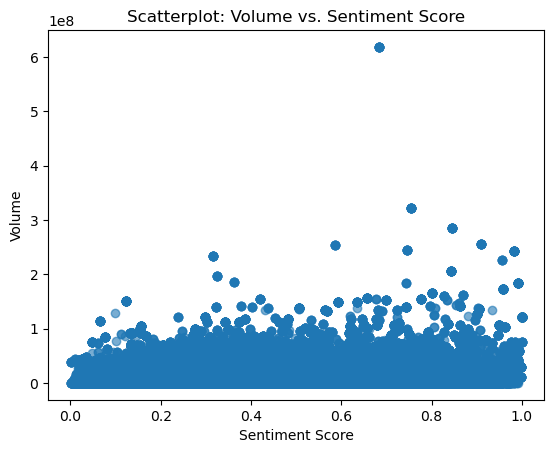

In [56]:
import matplotlib.pyplot as plt
plt.scatter(test_df["ITI"], test_df["vol"], alpha=0.6)
plt.xlabel("Sentiment Score")
plt.ylabel("Volume")
plt.title("Scatterplot: Volume vs. Sentiment Score")
plt.show()


In [67]:
import statsmodels.formula.api as smf

# Modèle 1 : seulement le sentiment
model1 = smf.ols("vol ~ sentiment_score", data=test_df).fit()
print(model1.summary())

# Modèle 2 : ajout de l’interaction avec ITI
model2 = smf.ols("vol~ sentiment_score * ITI", data=test_df).fit()
print(model2.summary())

# Comparaison de R² ajusté
print("Amélioration du R² :", model2.rsquared_adj - model1.rsquared_adj)


                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2922.
Date:                Tue, 14 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:25:15   Log-Likelihood:            -1.7083e+07
No. Observations:              977019   AIC:                         3.417e+07
Df Residuals:                  977017   BIC:                         3.417e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.417e+06   9712.759    4

In [68]:
from patsy import bs
m_spline = smf.ols("log_vol ~ bs(z_sentiment, df=5) + z_ITI + bs(z_sentiment, df=5):z_ITI + on_rdq", data=df_pd)\
               .fit(cov_type="cluster", cov_kwds={"groups": df_pd["permco"]})
print(m_spline.summary())


                            OLS Regression Results                            
Dep. Variable:                log_vol   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     176.9
Date:                Tue, 14 Oct 2025   Prob (F-statistic):          3.46e-302
Time:                        13:25:43   Log-Likelihood:            -2.1289e+06
No. Observations:              977019   AIC:                         4.258e+06
Df Residuals:                  977006   BIC:                         4.258e+06
Df Model:                          12                                         
Covariance Type:              cluster                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [ ]:
import statsmodels.formula.api as smf

# Modèle 1 : seulement le sentiment
model1 = smf.ols("next_day_ret ~ sentiment_score", data=filter_df).fit()
print(model1.summary())

# Modèle 2 : ajout de l’interaction avec ITI
model2 = smf.ols("next_day_ret ~ sentiment_score * ITI", data=filter_df).fit()
print(model2.summary())

# Comparaison de R² ajusté
print("Amélioration du R² :", model2.rsquared_adj - model1.rsquared_adj)


                            OLS Regression Results                            
Dep. Variable:           next_day_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2763
Date:                Tue, 14 Oct 2025   Prob (F-statistic):              0.599
Time:                        11:56:50   Log-Likelihood:             2.0578e+06
No. Observations:             1046018   AIC:                        -4.116e+06
Df Residuals:                 1046016   BIC:                        -4.116e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0008   3.35e-05     

In [ ]:
df_daily = filter_df.group_by(["permco", "date"]).agg([
    pl.mean("sentiment_score").alias("sentiment_mean"),
    pl.mean("ITI"),
    pl.mean("next_day_ret").alias("next_day_ret"),
])

df_daily

permco,date,sentiment_mean,ITI,next_day_ret
i64,date,f64,f64,f64
44885,2015-07-06,-0.951896,0.432702,-0.001623
13304,2018-02-15,0.446676,0.436278,0.001975
6883,2016-11-01,-0.034364,0.018601,0.00636
21763,2012-06-28,-0.010636,0.6263862,-0.012451
46697,2018-08-01,-0.005777,0.1781747,0.014641
…,…,…,…,…
53476,2013-10-24,-0.262554,0.068255,0.013413
20902,2010-05-27,0.004786,0.350752,-0.025925
21244,2015-06-30,-0.330586,0.258315,-0.001214


In [ ]:
ns = [5, 10, 20, 100] # EMA window sizes

for n in ns:
    df_daily = (
        df_daily
        .sort(["permco", "date"])
        .with_columns([
            pl.col("sentiment_mean")
            .ewm_mean(alpha=2/(n+1), adjust=False)
            .over("permco")
            .alias(f"ema_sentiment_{n}_mean")
        ])
    )

df_daily

permco,date,sentiment_mean,ITI,next_day_ret,ema_sentiment_5_mean,ema_sentiment_10_mean,ema_sentiment_20_mean,ema_sentiment_100_mean
i64,date,f64,f64,f64,f64,f64,f64,f64
37,2010-08-04,0.136093,0.030262,0.027066,0.136093,0.136093,0.136093,0.136093
37,2010-09-10,-0.002619,0.1824342,-0.001452,0.089856,0.110873,0.122883,0.133346
37,2010-09-13,-0.220451,0.481816,-0.142386,-0.01358,0.050632,0.090184,0.126341
37,2010-09-28,0.357624,0.509262,0.006736,0.110155,0.106449,0.115655,0.13092
37,2010-10-26,0.138449,0.185055,0.015251,0.119586,0.112267,0.117826,0.13107
…,…,…,…,…,…,…,…,…
56668,2019-07-25,-0.304784,0.3168921,-0.000887,-0.07637,-0.013631,0.034346,0.398043
56668,2019-07-26,-0.089615,0.566131,-0.000601,-0.080785,-0.027446,0.02254,0.388387
56668,2019-07-29,-0.191168,0.252577,-0.006,-0.117579,-0.057214,0.002187,0.37691


In [ ]:
# Split into 10 quantiles based on ITI and perform OLS analysis in each quantile
q10 = df_daily["ITI"].quantile(0.1)
q90 = df_daily["ITI"].quantile(0.9)

df_daily_tail_10 = df_daily.filter(pl.col("ITI") <= q10)
df_daily_top_10 = df_daily.filter(pl.col("ITI") >= q90)

# --- Top 10% ITI ---
print("Top 10% ITI")
# Modèle 1 : seulement le sentiment
model1_top = smf.ols("next_day_ret ~ sentiment_mean", data=df_daily_top_10).fit()
print(model1_top.adjusted_rsquare)
# Modèle 2 : ajout de l’interaction avec ITI
model2_top = smf.ols("next_day_ret ~ sentiment_mean * ITI", data=df_daily_top_10).fit()
print(model2_top.summary())
# Modele 3 : interaction avec 

# --- Tail 10% ITI ---
print("Tail 10% ITI")
# Modèle 1 : seulement le sentiment
model1_tail = smf.ols("next_day_ret ~ sentiment_mean", data=df_daily_tail_10).fit()
print(model1_tail.summary())
# Modèle 2 : ajout de l’interaction avec ITI
model2_tail = smf.ols("next_day_ret ~ sentiment_mean * ITI", data=df_daily_tail_10).fit()
print(model2_tail.summary())

Top 10% ITI


AttributeError: 'OLSResults' object has no attribute 'adjusted_rsquare'

In [ ]:
import polars as pl
import statsmodels.formula.api as smf

# --- Préparer le dataset Polars ---
df_pd = df_daily.to_pandas()  # pour statsmodels

# --- Calcul des quantiles ITI ---
q10 = df_daily["ITI"].quantile(0.1)
q90 = df_daily["ITI"].quantile(0.9)

df_tail_10 = df_daily.filter(pl.col("ITI") <= q10).to_pandas()
df_top_10  = df_daily.filter(pl.col("ITI") >= q90).to_pandas()

# --- Définition de la fonction de test ---
def run_tests(df, label):
    tests = {
        "Sentiment only": "next_day_ret ~ sentiment_mean",
        "Sentiment * ITI": "next_day_ret ~ sentiment_mean * ITI",
        "Sentiment quadratic": "next_day_ret ~ sentiment_mean + I(sentiment_mean**2)",
        "EMA 5": "next_day_ret ~ ema_sentiment_5_mean",
        "EMA 5 * ITI": "next_day_ret ~ ema_sentiment_5_mean * ITI",
        "EMA 10": "next_day_ret ~ ema_sentiment_10_mean",
        "EMA 10 * ITI": "next_day_ret ~ ema_sentiment_10_mean * ITI",
        "EMA 20": "next_day_ret ~ ema_sentiment_20_mean",
        "EMA 20 * ITI": "next_day_ret ~ ema_sentiment_20_mean * ITI",
        "Absolute sentiment": "next_day_ret ~ abs(sentiment_mean)",
        "Absolute sentiment * ITI": "next_day_ret ~ abs(sentiment_mean) * ITI",
    }

    print(f"--- {label} ---")
    for test_name, formula in tests.items():
        try:
            model = smf.ols(formula, data=df).fit()
            print(f"{test_name}: adj R² = {model.rsquared_adj:.6f}")
        except Exception as e:
            print(f"{test_name}: error ({e})")

# --- Tests sur tout le dataset ---
run_tests(df_pd, "Full dataset")

# --- Tests Top 10% ITI ---
run_tests(df_top_10, "Top 10% ITI")

# --- Tests Bottom 10% ITI ---
run_tests(df_tail_10, "Bottom 10% ITI")


--- Full dataset ---
Sentiment only: adj R² = -0.000002
Sentiment * ITI: adj R² = -0.000003
Sentiment quadratic: adj R² = -0.000003
EMA 5: adj R² = -0.000001
EMA 5 * ITI: adj R² = 0.000002
EMA 10: adj R² = -0.000001
EMA 10 * ITI: adj R² = 0.000002
EMA 20: adj R² = -0.000001
EMA 20 * ITI: adj R² = -0.000000
Absolute sentiment: adj R² = -0.000002
Absolute sentiment * ITI: adj R² = -0.000004
--- Top 10% ITI ---
Sentiment only: adj R² = -0.000003
Sentiment * ITI: adj R² = -0.000013
Sentiment quadratic: adj R² = -0.000018
EMA 5: adj R² = 0.000086
EMA 5 * ITI: adj R² = 0.000079
EMA 10: adj R² = 0.000091
EMA 10 * ITI: adj R² = 0.000075
EMA 20: adj R² = 0.000068
EMA 20 * ITI: adj R² = 0.000048
Absolute sentiment: adj R² = -0.000010
Absolute sentiment * ITI: adj R² = 0.000063
--- Bottom 10% ITI ---
Sentiment only: adj R² = 0.000029
Sentiment * ITI: adj R² = 0.000001
Sentiment quadratic: adj R² = 0.000013
EMA 5: adj R² = -0.000010
EMA 5 * ITI: adj R² = -0.000039
EMA 10: adj R² = -0.000015
EMA 10

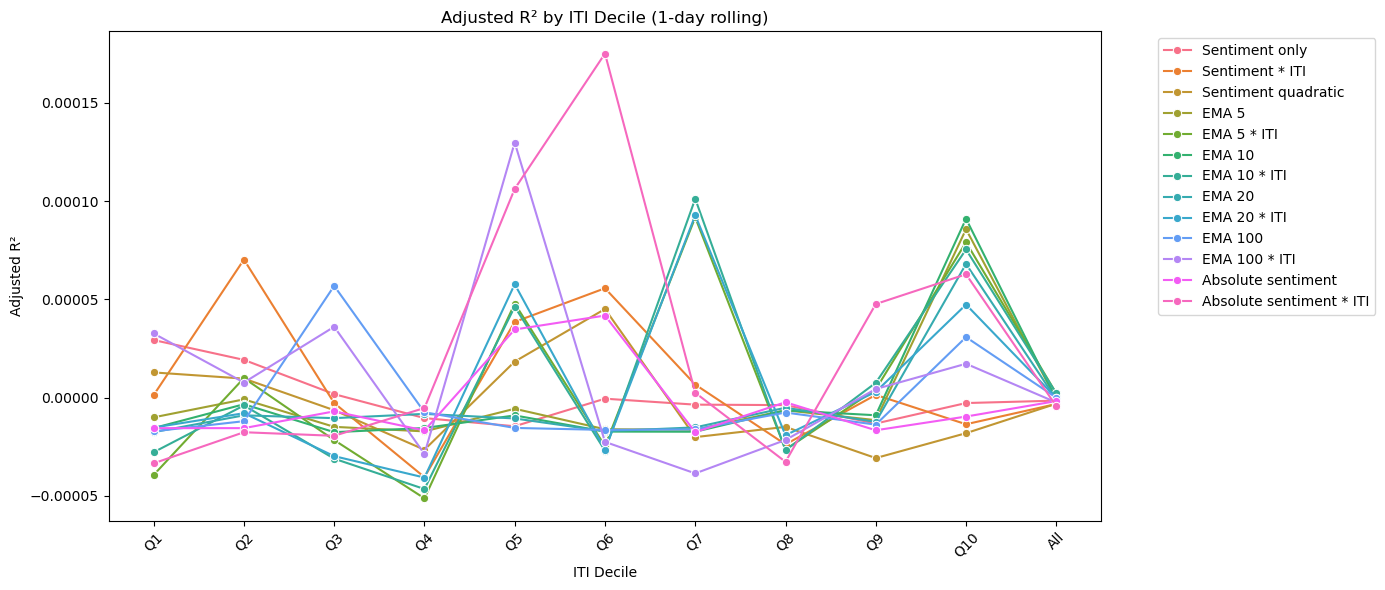

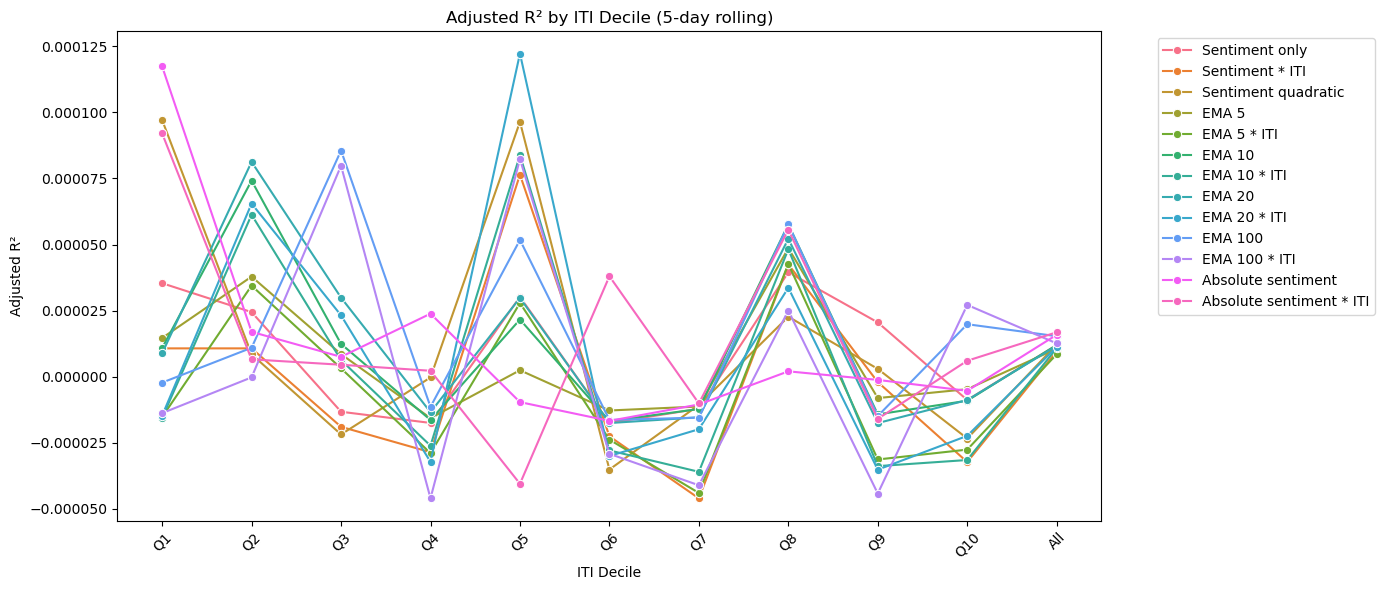

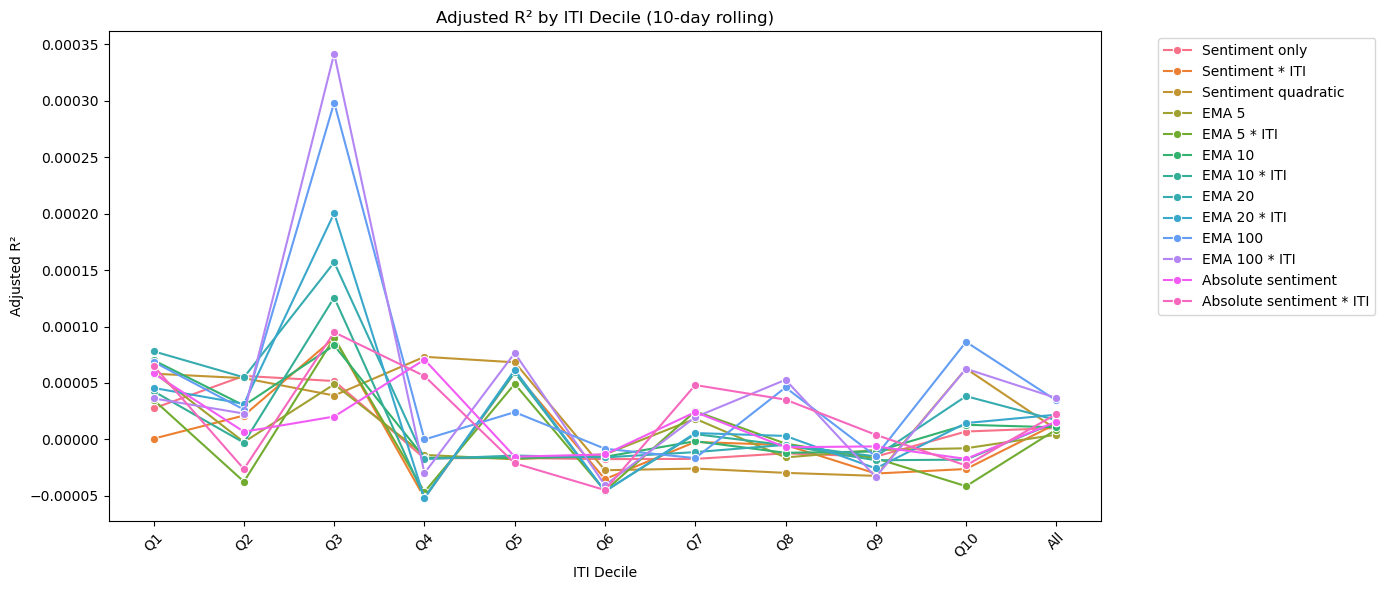

In [ ]:
import polars as pl
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Rolling window sizes to consider ---
window_sizes = [1, 5, 10]  # in days

# --- Dictionary of regression tests ---
tests = {
    "Sentiment only": "next_day_ret ~ sentiment_mean",
    "Sentiment * ITI": "next_day_ret ~ sentiment_mean * ITI",
    "Sentiment quadratic": "next_day_ret ~ sentiment_mean + I(sentiment_mean**2)",
    "EMA 5": "next_day_ret ~ ema_sentiment_5_mean",
    "EMA 5 * ITI": "next_day_ret ~ ema_sentiment_5_mean * ITI",
    "EMA 10": "next_day_ret ~ ema_sentiment_10_mean",
    "EMA 10 * ITI": "next_day_ret ~ ema_sentiment_10_mean * ITI",
    "EMA 20": "next_day_ret ~ ema_sentiment_20_mean",
    "EMA 20 * ITI": "next_day_ret ~ ema_sentiment_20_mean * ITI",
    "Absolute sentiment": "next_day_ret ~ abs(sentiment_mean)",
    "Absolute sentiment * ITI": "next_day_ret ~ abs(sentiment_mean) * ITI",
}

# --- Function to compute rolling means for returns and sentiment ---
def add_rolling_means(df, window):
    # Sort by stock (permco) and date
    df = df.sort(["permco", "date"])
    # Compute rolling mean over the window for each stock
    df = df.with_columns([
        pl.col("next_day_ret").rolling_mean(window, min_samples=1).over("permco").alias(f"ret_mean_{window}"),
        pl.col("sentiment_mean").rolling_mean(window, min_samples=1).over("permco").alias(f"sent_mean_{window}")
    ])
    return df

# --- Function to run regressions and collect adjusted R² ---
def run_tests_collect(df, window_label):
    results = []
    df_pd = df.to_pandas()
    
    # --- Full dataset regressions ---
    for name, formula in tests.items():
        try:
            model = smf.ols(formula, data=df_pd).fit()
            results.append({"window": window_label, "decile": "All", "test": name, "adj_r2": model.rsquared_adj})
        except:
            results.append({"window": window_label, "decile": "All", "test": name, "adj_r2": None})
    
    # --- Decile-based regressions ---
    df_pd["ITI_decile"] = pd.qcut(df_pd["ITI"], 10, labels=[f"Q{i}" for i in range(1, 11)])
    for decile in df_pd["ITI_decile"].cat.categories:
        df_decile = df_pd[df_pd["ITI_decile"] == decile]
        for name, formula in tests.items():
            try:
                model = smf.ols(formula, data=df_decile).fit()
                results.append({"window": window_label, "decile": decile, "test": name, "adj_r2": model.rsquared_adj})
            except:
                results.append({"window": window_label, "decile": decile, "test": name, "adj_r2": None})
    return results

# --- Loop over rolling windows and collect results ---
all_results = []
for w in window_sizes:
    # Compute rolling averages
    df_window = add_rolling_means(df_daily, w)
    
    # Replace next_day_ret and sentiment_mean with rolling averages
    df_window_for_test = df_window.with_columns([
        pl.col(f"ret_mean_{w}").alias("next_day_ret"),
        pl.col(f"sent_mean_{w}").alias("sentiment_mean")
    ])
    
    # Run regressions and store results
    all_results.extend(run_tests_collect(df_window_for_test, f"{w}-day rolling"))

# --- Convert results to pandas DataFrame for plotting ---
df_results = pd.DataFrame(all_results)

# --- Ensure ITI decile ordering including "All" ---
decile_order = [f"Q{i}" for i in range(1, 11)] + ["All"]
df_results['decile'] = pd.Categorical(df_results['decile'], categories=decile_order, ordered=True)

# --- Loop to create a plot for each rolling window ---
for w in window_sizes:
    window_label = f"{w}-day rolling"
    plt.figure(figsize=(14,6))
    sns.lineplot(
        data=df_results[df_results['window'] == window_label],
        x='decile', y='adj_r2', hue='test', marker="o"
    )
    plt.title(f"Adjusted R² by ITI Decile ({window_label})")
    plt.xlabel("ITI Decile")
    plt.ylabel("Adjusted R²")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
test = test_df.with_columns(pl.col('Article_title').str.)